Name: Akanksha Dhote
NetID: avd8874

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tqdm import tqdm
import h5py
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
cl_data_valid = 'cl/valid.h5'
bd_data_valid = 'bd/bd_valid.h5'
bd_net_model = 'bd_net.h5'

In [4]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [5]:
bd_model = keras.models.load_model(bd_net_model)

cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

In [6]:
cl_label_p = np.argmax(bd_model.predict(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid))*100
print('Clean Classification accuracy:', clean_accuracy)

bd_label_p = np.argmax(bd_model.predict(bd_x_valid), axis=1)
success_rate = np.mean(np.equal(bd_label_p, bd_y_valid))*100
print('Attack Success Rate:', success_rate)

361/361 [==============================] - 2s 5ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate: 100.0


In [7]:
print(bd_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [8]:
output_classes = bd_model.layers[-1].output_shape[-1]
print("Number of output classes (N):", output_classes)

Number of output classes (N): 1283


In [9]:
# get the data
cl_x_valid, cl_y_valid = data_loader(cl_data_valid)
bd_x_valid, bd_y_valid = data_loader(bd_data_valid)

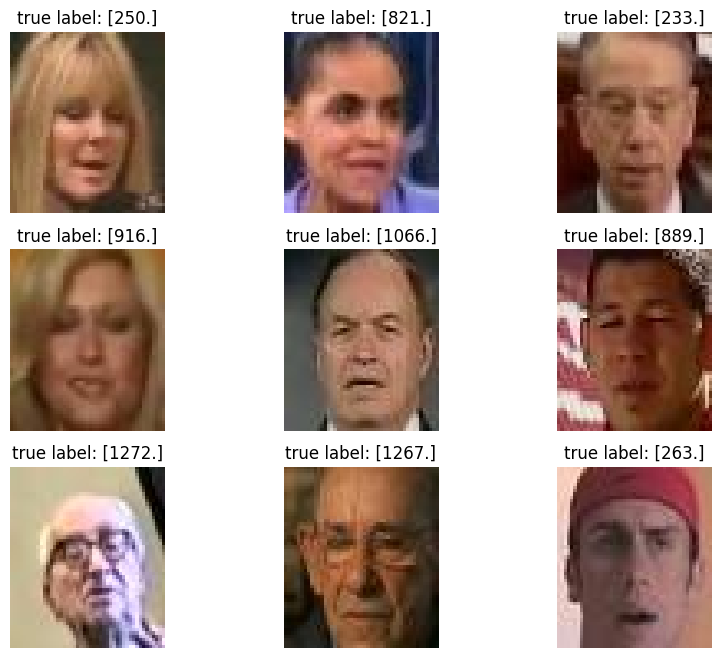

In [10]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(cl_x_valid.shape[0], size=1)
  img, label = (cl_x_valid[index], cl_y_valid[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

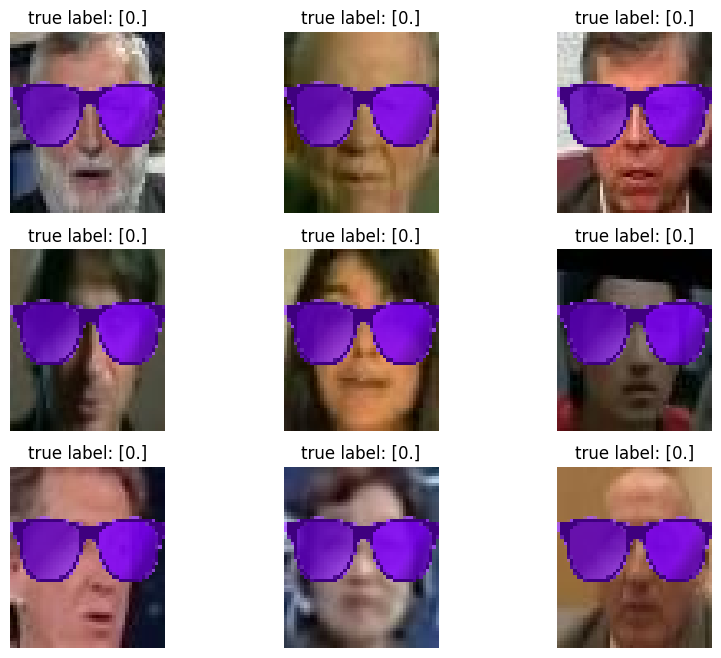

In [11]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(bd_x_valid.shape[0], size=1)
  img, label = (bd_x_valid[index], bd_y_valid[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [12]:
# clearing the session
keras.backend.clear_session()

In [13]:
clean_data_acc = clean_accuracy
clean_acc_list = []
success_rate_list = []

model_copy = keras.models.clone_model(bd_model)
model_copy.set_weights(bd_model.get_weights())
saved_models = np.zeros(4, dtype=bool)

# activation extraction from the last pooling layer - pool_3
pool3_layer = model_copy.get_layer('pool_3').output
new_model = keras.models.Model(inputs=model_copy.input, outputs=pool3_layer)
new_pred = new_model.predict(cl_x_valid)

temp = np.mean(new_pred, axis = (0, 1, 2))
# seq = np.argsort(temp)[::-1] # descending order of activation
seq = np.argsort(temp)
print(temp)
print(seq)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 1s 4ms/step
[0.0000000e+00 8.5787809e-01 0.0000000e+00 5.3079778e-01 5.1451392e+00
 2.0289583e+00 6.2408661e-03 5.3690352e+00 2.1106055e+00 0.0000000e+00
 4.1488924e+00 2.1980379e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654891e+00 0.0000000e+00 5.0868411e+00 2.4381575e-01
 1.8378231e-01 8.3539166e-02 4.3979678e-02 3.0290761e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440871e+00 1.0589780e+00
 0.0000000e+00 0.0000000e+00 1.5006668e-02 0.0000000e+00 0.0000000e+00
 4.8648086e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658589e-01 4.2763174e-01 0.0000000e+00
 0.0000000e+00 1.8540378e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321567e-02 6.2038708e+00 0.0000000e+00 3.6191158e+00
 0.0000000e+00 1.6352932e+00 8.2229834e+00 5.0732869e-01 0.0000000e+00]
[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 

In [14]:
# Pruning the channel
for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_valid), axis=1)
  clean_acc = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

  if (clean_data_acc - clean_acc >= 2 and not saved_models[0]):
    print("The accuracy drops at least 2%, saved the model", clean_acc)
    model_copy.save('model_X=2.h5')
    saved_models[0] = 1
  if (clean_data_acc - clean_acc >= 4 and not saved_models[1]):
    print("The accuracy drops at least 4%, saved the model", clean_acc)
    model_copy.save('model_X=4.h5')
    saved_models[1] = 1
  if (clean_data_acc - clean_acc >= 10 and not saved_models[2]):
    print("The accuracy drops at least 10%, saved the model", clean_acc)
    model_copy.save('model_X=10.h5')
    saved_models[2] = 1
  if (clean_data_acc - clean_acc >= 25 and not saved_models[3]):
    print("The accuracy drops at least 25%, saved the model", clean_acc)
    model_copy.save('model_X=25.h5')
    saved_models[3] = 1

  clean_acc_list.append(clean_acc)
  bd_pred = np.argmax(model_copy.predict(bd_x_valid), axis=1)
  success_rate = np.mean(np.equal(bd_pred, bd_y_valid)) * 100
  success_rate_list.append(success_rate)
  
  print("The pruned channel index is: ", channel_index)
  print("The clean accuracy is: ", clean_accuracy)
  print("The attack success rate is: ", success_rate)
  
  keras.backend.clear_session()


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 2s 5ms/step


  2%|▏         | 1/60 [00:05<05:22,  5.46s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 2s 5ms/step


  3%|▎         | 2/60 [00:10<05:05,  5.26s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|▌         | 3/60 [00:15<05:01,  5.28s/it]

361/361 [==============================] - 2s 5ms/step


  7%|▋         | 4/60 [00:21<04:58,  5.32s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 2s 5ms/step


  8%|▊         | 5/60 [00:26<04:45,  5.19s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 2s 5ms/step


 10%|█         | 6/60 [00:30<04:27,  4.95s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 12%|█▏        | 7/60 [00:35<04:25,  5.01s/it]

361/361 [==============================] - 2s 5ms/step


 13%|█▎        | 8/60 [00:40<04:20,  5.00s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 2s 5ms/step


 15%|█▌        | 9/60 [00:45<04:04,  4.80s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 2s 5ms/step


 17%|█▋        | 10/60 [00:50<04:05,  4.90s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 2s 5ms/step


 18%|█▊        | 11/60 [00:55<04:03,  4.98s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 2s 5ms/step


 20%|██        | 12/60 [01:00<03:52,  4.85s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 2s 5ms/step


 22%|██▏       | 13/60 [01:05<03:51,  4.92s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 2s 5ms/step


 23%|██▎       | 14/60 [01:10<03:47,  4.94s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 2s 5ms/step


 25%|██▌       | 15/60 [01:14<03:37,  4.84s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 2s 5ms/step


 27%|██▋       | 16/60 [01:20<03:39,  5.00s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 2s 5ms/step


 28%|██▊       | 17/60 [01:25<03:37,  5.07s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 2s 5ms/step


 30%|███       | 18/60 [01:30<03:28,  4.97s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50


 32%|███▏      | 19/60 [01:35<03:28,  5.09s/it]

361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53


 33%|███▎      | 20/60 [01:40<03:23,  5.10s/it]

361/361 [==============================] - 2s 5ms/step


 35%|███▌      | 21/60 [01:45<03:12,  4.94s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 2s 5ms/step


 37%|███▋      | 22/60 [01:50<03:13,  5.10s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 2s 5ms/step
The clean accuracy is: 

 38%|███▊      | 23/60 [01:55<03:09,  5.11s/it]

 98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 2s 5ms/step


 40%|████      | 24/60 [02:00<02:58,  4.95s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 2s 5ms/step


 42%|████▏     | 25/60 [02:05<02:58,  5.11s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 2s 5ms/step


 43%|████▎     | 26/60 [02:10<02:54,  5.14s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 2s 5ms/step


 45%|████▌     | 27/60 [02:15<02:44,  4.97s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 2s 5ms/step


 47%|████▋     | 28/60 [02:20<02:43,  5.11s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 2s 5ms/step


 48%|████▊     | 29/60 [02:26<02:39,  5.16s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 2s 5ms/step


 50%|█████     | 30/60 [02:30<02:30,  5.01s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 2s 5ms/step


 52%|█████▏    | 31/60 [02:36<02:28,  5.11s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 2s 6ms/step


 53%|█████▎    | 32/60 [02:41<02:27,  5.26s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 2s 5ms/step


 55%|█████▌    | 33/60 [02:46<02:18,  5.15s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 2s 5ms/step


 57%|█████▋    | 34/60 [02:52<02:16,  5.25s/it]

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 2s 5ms/step


 58%|█████▊    | 35/60 [02:57<02:11,  5.28s/it]

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 2s 5ms/step


 60%|██████    | 36/60 [03:02<02:03,  5.13s/it]

The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 2s 5ms/step


 62%|██████▏   | 37/60 [03:07<02:00,  5.22s/it]

The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 2s 5ms/step


 63%|██████▎   | 38/60 [03:14<02:05,  5.72s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 2s 5ms/step


 65%|██████▌   | 39/60 [03:19<01:54,  5.45s/it]

The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 2s 6ms/step


 67%|██████▋   | 40/60 [03:25<01:49,  5.47s/it]

The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 2s 5ms/step


 68%|██████▊   | 41/60 [03:30<01:43,  5.46s/it]

The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 2s 5ms/step


 70%|███████   | 42/60 [03:35<01:34,  5.26s/it]

The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 2s 5ms/step


 72%|███████▏  | 43/60 [03:40<01:31,  5.39s/it]

The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 2s 5ms/step


 73%|███████▎  | 44/60 [03:46<01:25,  5.36s/it]

The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 2%, saved the model 95.75647354291158
361/361 [==============================] - 2s 5ms/step


 75%|███████▌  | 45/60 [03:51<01:19,  5.29s/it]

The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 2s 6ms/step


 77%|███████▋  | 46/60 [03:57<01:17,  5.52s/it]

The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 2s 6ms/step


 78%|███████▊  | 47/60 [04:02<01:11,  5.51s/it]

The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 2s 6ms/step
The accuracy drops at least 4%, saved the model 92.09318437689443
361/361 [==============================] - 2s 5ms/step


 80%|████████  | 48/60 [04:07<01:04,  5.39s/it]

The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 2s 6ms/step


 82%|████████▏ | 49/60 [04:13<01:00,  5.47s/it]

The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 2s 6ms/step


 83%|████████▎ | 50/60 [04:19<00:54,  5.47s/it]

The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 2s 5ms/step


 85%|████████▌ | 51/60 [04:23<00:47,  5.29s/it]

The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 10%, saved the model 84.43751623798389
361/361 [==============================] - 2s 5ms/step


 87%|████████▋ | 52/60 [04:29<00:43,  5.43s/it]

The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 2s 5ms/step


 88%|████████▊ | 53/60 [04:35<00:37,  5.40s/it]

The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 2s 5ms/step
The accuracy drops at least 25%, saved the model 54.8627349095003
361/361 [==============================] - 2s 6ms/step


 90%|█████████ | 54/60 [04:39<00:31,  5.25s/it]

The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 2s 5ms/step


 92%|█████████▏| 55/60 [04:45<00:26,  5.36s/it]

The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 2s 6ms/step


 93%|█████████▎| 56/60 [04:51<00:21,  5.40s/it]

The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 2s 5ms/step


 95%|█████████▌| 57/60 [04:55<00:15,  5.24s/it]

The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 2s 6ms/step


 97%|█████████▋| 58/60 [05:01<00:10,  5.42s/it]

The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 2s 6ms/step


 98%|█████████▊| 59/60 [05:07<00:05,  5.47s/it]

The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 2s 5ms/step
The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


100%|██████████| 60/60 [05:12<00:00,  5.21s/it]


In [15]:
print("clean_accuracy: ", clean_acc_list)
print("attack success rate: ", success_rate_list)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

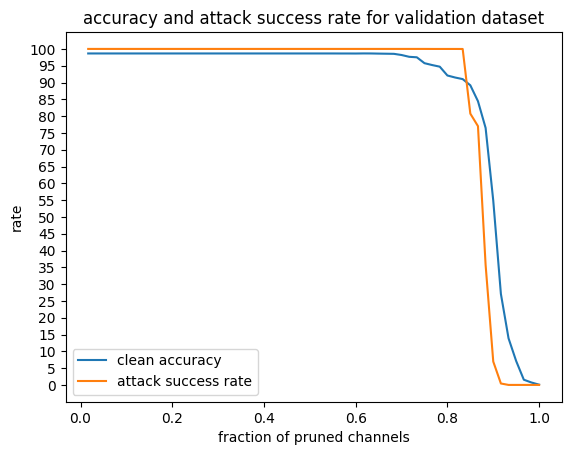

In [35]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis, clean_acc_list)
plt.plot(x_axis, success_rate_list)
plt.yticks(np.arange(0, 105, step=5))
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.legend(['clean accuracy','attack success rate'])
plt.title("accuracy vs attack success rate for validation dataset")

##Expected output model

In [17]:
class G(keras.Model):
  def __init__(self, M, M_new):
      super(G, self).__init__()
      self.M = M
      self.M_new = M_new

  def predict(self, data):
      y = np.argmax(self.M(data), axis=1)
      y_new = np.argmax(self.M_new(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i] == y_new[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1284 # N + 1 when classification outputs differ
      return pred

In [18]:
# get test data
cl_test_data = 'cl/test.h5'
bd_test_data = 'bd/bd_test.h5'

In [19]:
# get the stored models
file_model_X2 = 'model_X=2.h5'
file_model_X4 = 'model_X=4.h5'
file_model_X10 = 'model_X=10.h5'
file_model_X25 = 'model_X=25.h5'

model_X2 = keras.models.load_model(file_model_X2)
model_X4 = keras.models.load_model(file_model_X4)
model_X10 = keras.models.load_model(file_model_X10)
model_X25 = keras.models.load_model(file_model_X25)

In [20]:
x_test_cl, y_test_cl = data_loader(cl_test_data)
x_test_bd, y_test_bd = data_loader(bd_test_data)

In [36]:
print("x_test_cl_data shape: ",x_test_cl.shape)
print("x_test_bd_data data shape: ",x_test_bd.shape)

x_test_cl_data shape:  (12830, 55, 47, 3)
x_test_bd_data data shape:  (12830, 55, 47, 3)


In [22]:
# combining the models
G_model_X2 = G(bd_model, model_X2)
G_model_X4 = G(bd_model, model_X4)
G_model_X10 = G(bd_model, model_X10)
G_model_X25 = G(bd_model, model_X25)

#Evaluating on the test dataset

In [23]:
cl_2_pred = np.argmax(model_X2.predict(x_test_cl), axis=1)
acc_2 = np.mean(np.equal(cl_2_pred, y_test_cl)) * 100
print('Classification accuracy on the clean test data for 2% drops model:', acc_2)

bd_2_pred = np.argmax(model_X2.predict(x_test_bd), axis=1)
success_rate_2 = np.mean(np.equal(bd_2_pred, y_test_bd)) * 100
print('Attack Success Rate for 2% drops model:', success_rate_2)

401/401 [==============================] - 2s 5ms/step
Classification accuracy on the clean test data for 2% drops model: 95.90023382696803
401/401 [==============================] - 3s 7ms/step
Attack Success Rate for 2% drops model: 100.0


In [24]:
cl_4_pred = np.argmax(model_X4.predict(x_test_cl), axis=1)
acc_4 = np.mean(np.equal(cl_4_pred, y_test_cl)) * 100
print('Classification accuracy on the clean test data for 4% drops model:', acc_4)

bd_4_pred = np.argmax(model_X4.predict(x_test_bd), axis=1)
success_rate_4 = np.mean(np.equal(bd_4_pred, y_test_bd)) * 100
print('Attack Success Rate for 4% drops model:', success_rate_4)

401/401 [==============================] - 3s 6ms/step
Classification accuracy on the clean test data for 4% drops model: 92.29150428682775
401/401 [==============================] - 2s 5ms/step
Attack Success Rate for 4% drops model: 99.98441153546376


In [25]:
cl_10_pred = np.argmax(model_X10.predict(x_test_cl), axis=1)
acc_10 = np.mean(np.equal(cl_10_pred, y_test_cl)) * 100
print('Classification accuracy on the clean test data for 10% drops model:', acc_10)

bd_10_pred = np.argmax(model_X10.predict(x_test_bd), axis=1)
success_rate_10 = np.mean(np.equal(bd_10_pred, y_test_bd)) * 100
print('Attack Success Rate for 10% drops model:', success_rate_10)

401/401 [==============================] - 2s 5ms/step
Classification accuracy on the clean test data for 10% drops model: 84.54403741231489
401/401 [==============================] - 2s 6ms/step
Attack Success Rate for 10% drops model: 77.20966484801247


In [26]:
cl_25_pred = np.argmax(model_X25.predict(x_test_cl), axis=1)
acc_25 = np.mean(np.equal(cl_25_pred, y_test_cl)) * 100
print('Classification accuracy on the clean test data for 25% drops model:', acc_25)

bd_25_pred = np.argmax(model_X25.predict(x_test_bd), axis=1)
success_rate_25 = np.mean(np.equal(bd_25_pred, y_test_bd)) * 100
print('Attack Success Rate for 25% drops model:', success_rate_25)

401/401 [==============================] - 2s 6ms/step
Classification accuracy on the clean test data for 25% drops model: 54.762275915822286
401/401 [==============================] - 2s 6ms/step
Attack Success Rate for 25% drops model: 6.96024941543258


In [27]:
attack_success_rate = [success_rate_2, success_rate_4, success_rate_10, success_rate_25]
test_acc = [acc_2, acc_4, acc_10, acc_25]

data = {
    "text_acc": test_acc,
    "model": ["2%_repaired", "4%_repaired", "10%_repaired", "25%_repaired"],
    "attack_rate": attack_success_rate,
}

df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
2%_repaired,95.900234,100.000000
4%_repaired,92.291504,99.984412
10%_repaired,84.544037,77.209665
25%_repaired,54.762276,6.960249


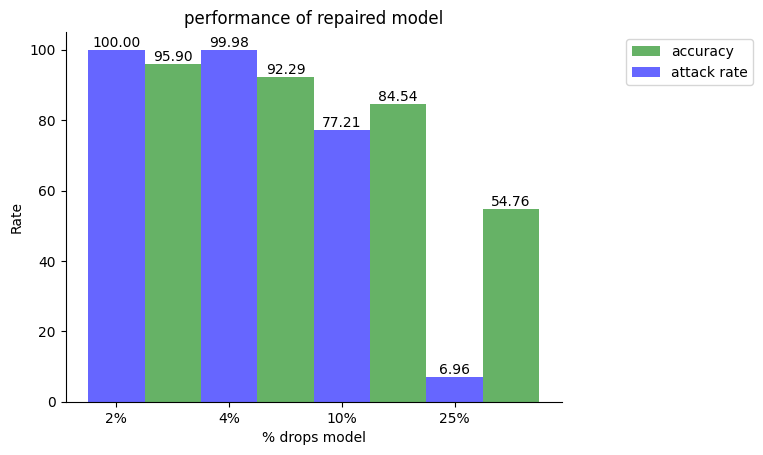

In [28]:
opacity = 0.6
bar_width = 0.5

bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='green', label='accuracy')
bar2 = plt.bar(range(len(attack_success_rate)), attack_success_rate, bar_width, align='center', alpha=opacity, color='blue', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xlabel('% drops model')
plt.ylabel('Rate')
plt.xticks(range(len(test_acc)),('2%', '4%', '10%', '25%'))
plt.legend(bbox_to_anchor=(1.4, 1))
plt.title('performance of repaired model')
sns.despine()
plt.show()

#Evaluating the combined models

In [29]:
G_cl_2_pred = G_model_X2.predict(x_test_cl)
G_acc_2 = np.mean(np.equal(G_cl_2_pred, y_test_cl))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_acc_2)

G_bd_2_pred = G_model_X2.predict(x_test_bd)
G_success_rate_2 = np.mean(np.equal(G_bd_2_pred, y_test_bd))*100
print('Combined 2% drops model, Attack Success Rate:', G_success_rate_2)

Combined 2% drops model, the clean test data Classification accuracy: 95.74434918160561
Combined 2% drops model, Attack Success Rate: 100.0


In [30]:
G_cl_4_pred = G_model_X4.predict(x_test_cl)
G_acc_4 = np.mean(np.equal(G_cl_4_pred, y_test_cl))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_acc_4)

G_bd_4_pred = G_model_X4.predict(x_test_bd)
G_success_rate_4 = np.mean(np.equal(G_bd_4_pred, y_test_bd))*100
print('Combined 4% drops model, Attack Success Rate:', G_success_rate_4)

Combined 4% drops model, the clean test data Classification accuracy: 92.1278254091972
Combined 4% drops model, Attack Success Rate: 99.98441153546376


In [31]:
G_cl_10_pred = G_model_X10.predict(x_test_cl)
G_acc_10 = np.mean(np.equal(G_cl_10_pred, y_test_cl))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_acc_10)

G_bd_10_pred = G_model_X10.predict(x_test_bd)
G_success_rate_10 = np.mean(np.equal(G_bd_10_pred, y_test_bd))*100
print('Combined 10% drops model, Attack Success Rate:', G_success_rate_10)

Combined 10% drops model, the clean test data Classification accuracy: 84.3335931410756
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [32]:
G_cl_25_pred = G_model_X25.predict(x_test_cl)
G_acc_25 = np.mean(np.equal(G_cl_25_pred, y_test_cl))*100
print('Combined 25% drops model, the clean test data Classification accuracy:', G_acc_25)

G_bd_25_pred = G_model_X25.predict(x_test_bd)
G_success_rate_25 = np.mean(np.equal(G_bd_25_pred, y_test_bd))*100
print('Combined 25% drops model, Attack Success Rate:', G_success_rate_25)

Combined 25% drops model, the clean test data Classification accuracy: 54.67653936087296
Combined 25% drops model, Attack Success Rate: 6.96024941543258


In [33]:
G_attack_success_rate = [G_success_rate_2, G_success_rate_4, G_success_rate_10, G_success_rate_25]
G_acc = [G_acc_2, G_acc_4, G_acc_10, G_acc_25]

G_print_data = {
    "G_text_acc": G_acc,
    "G_model": ["G_2%", "G_4%", "G_10%", "G_25%"],
    "G_attack_success_rate": G_attack_success_rate,
}

G_df = pd.DataFrame(G_print_data)
G_df.set_index('G_model')


,G_text_acc,G_attack_success_rate
G_model,,
G_2%,95.744349,100.000000
G_4%,92.127825,99.984412
G_10%,84.333593,77.209665
G_25%,54.676539,6.960249


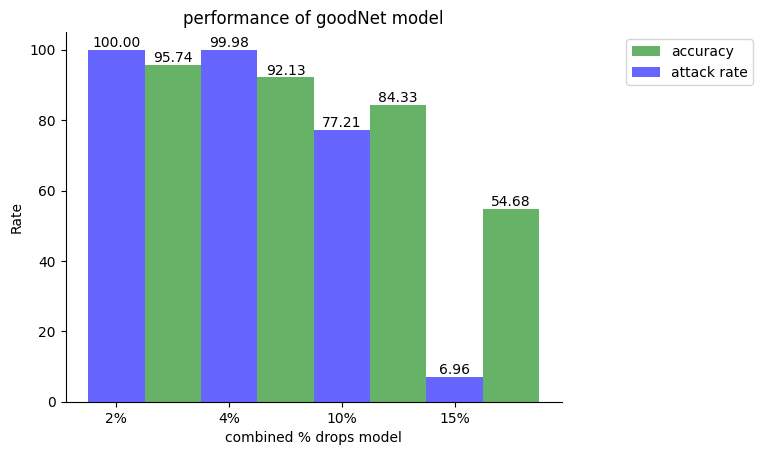

In [34]:
opacity = 0.6
bar_width = 0.5

bar1 = plt.bar(np.arange(len(G_acc)) + bar_width, G_acc, bar_width, align='center', alpha=opacity, color='green', label='accuracy')
bar2 = plt.bar(range(len(G_attack_success_rate)),G_attack_success_rate, bar_width, align='center', alpha=opacity, color='blue', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.xlabel('combined % drops model')
plt.ylabel('Rate')
plt.xticks(range(len(G_acc)),('2%', '4%', '10%', '15%'))
plt.legend(bbox_to_anchor=(1.4, 1))
plt.title('performance of goodNet model')
sns.despine()
plt.show()